In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly
from plotnine import *



In [54]:
results_mpc = pd.read_csv('mpc_results.csv')
results_mpc['timestamp'] = pd.to_datetime(results_mpc['timestamp'])

results_nn = pd.read_csv('hybrid_rl_results.csv')
results_nn['timestamp'] = pd.to_datetime(results_nn['timestamp'])

start = pd.Timestamp(year=2018,
                     month=10,
                     day=28,
                     hour=0,
                     minute=0)
end = pd.Timestamp(year=2018,
                     month=10,
                     day=30,
                     hour=0,
                     minute=0)

results_mpc_short = results_mpc[(results_mpc['timestamp'] > start) & (results_mpc['timestamp'] < end)]
results_nn_short = results_nn[(results_nn['timestamp'] > start) & (results_nn['timestamp'] < end)]

In [62]:
results_nn

Unnamed: 0 b_fcas_power  b_fcas_price b_fcas_type  b_fcas_actor_power  \
0              0     46.05535     41.000000         gen            3.874165   
1              1     66.31312     41.000000         gen            1.665301   
2              2   122.000725     41.000000         gen            5.804046   
3              3        200.0     41.670000         gen           15.012062   
4              4        200.0     47.670000         gen           44.327183   
...          ...          ...           ...         ...                 ...   
4577        4577    131.81499     49.653510         gen          131.814990   
4578        4578    140.42325     57.974120         gen          140.423250   
4579        4579    137.77126     58.604195         gen          137.771260   
4580        4580    134.85046     58.210530         gen          134.850460   
4581        4581    138.82372     62.758724         gen          138.823720   

      b_fcas_actor_price  b_en_actor_power  b_en_power_gen  b_en_power_load  \
0              -0.314283          2.030499        0.000000        300.00000   
1              -1.074649         13.283922        0.000000        300.00000   
2               3.831633         44.470318        0.000000        300.00000   
3              17.090618         93.441826        0.000000        243.99948   
4              32.088036        136.424350        0.000000        100.00000   
...                  ...               ...             ...              ...   
4577           49.653510        -11.397912      -11.397912          0.00000   
4578           57.974120         -9.703232       -9.703232          0.00000   
4579           58.604195         -8.249101       -8.249101          0.00000   
4580           58.210530         -7.481631       -7.481631          0.00000   
4581           62.758724         -4.654909       -4.654909          0.00000   

      b_en_price  ... fcas_clearing_price  en_price              r  \
0          54.90  ...           41.000000     54.90  -16101.012895   
1          56.19  ...           41.000000     56.19  -16488.012895   
2          58.73  ...           41.000000     58.73 -178250.362347   
3          62.98  ...           41.669998     62.98 -264301.249385   
4          74.24  ...           47.669998     74.24 -115042.990140   
...          ...  ...                 ...       ...            ...   
4577       82.11  ...           49.653511     82.11    1452.057904   
4578       84.28  ...           57.974121     84.28    2463.205003   
4579       84.52  ...           58.604195     84.52    1959.377297   
4580       84.86  ...           58.210529     84.86    1724.761013   
4581       84.88  ...           62.758724     84.88    2007.465394   

      current_state_value  next_state_value  fcas_demand          soe  \
0             -160.965973        -15.090668        41.00     0.000000   
1             -293.572388       -160.965973        41.00   295.000175   
2            -2017.214233       -293.572388        41.00   590.000349   
3            -4255.774414      -2017.214233        41.67   885.000524   
4            -4552.920898      -4255.774414        47.67  1029.000000   
...                   ...               ...          ...          ...   
4577           128.334686        142.356583        42.55   680.819439   
4578           127.235619        128.334686        62.54   663.646224   
4579           121.318649        127.235619        54.93   638.175261   
4580           114.241882        121.318649        51.80   617.961115   
4581           111.411034        114.241882        59.55   600.077874   

               timestamp    k        delta  
0    2018-06-01 04:30:00  0.0  -16112.4700  
1    2018-06-01 05:00:00  0.0  -16479.9650  
2    2018-06-01 05:30:00  0.0 -178235.6700  
3    2018-06-01 06:00:00  0.0 -264200.3800  
4    2018-06-01 06:30:00  0.0 -114830.2000  
...                  ...  ...          ...  
4577 2018-09-04 13:00:00  1.0    1444.9401  
4578 2018-09-04 13:30:00  1.0 

In [69]:
def compute_reward_mpc(results):
    reward = []
    for i in range(len(results)):
        r = (results['battery_bid_energy_power_gen'].iloc[i] - results['battery_bid_energy_power_load'].iloc[i]) * results['battery_bid_energy_price'].iloc[i]
        if results['battery_bid_fcas_price'].iloc[i] <= results['fcas_clearing_price'].iloc[i]:
            r += abs(results['battery_bid_fcas_price'].iloc[i] * results['battery_bid_fcas_power'].iloc[i])
        reward.append(r)
    results['reward'] = reward
    return results

def compute_reward_nn(results):
    reward = []
    for i in range(len(results)):
        r = (results['b_en_power_gen'].iloc[i] - results['b_en_power_load'].iloc[i]) * results['b_en_price'].iloc[i]
        if results['b_fcas_price'].iloc[i] <= results['fcas_clearing_price'].iloc[i]:
            r += abs(results['b_fcas_price'].iloc[i] * np.float(results['b_fcas_power'].iloc[i]))
        reward.append(r)
    results['reward'] = reward
    return results

In [70]:
results_mpc = compute_reward_mpc(results_mpc)
results_nn = compute_reward_nn(results_nn)

print(results_mpc['reward'].sum())
print(results_nn['reward'].sum())

<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>


ValueError: could not convert string to float: 'tensor(-1.0104e-07)'

In [44]:
cumulative_reward_mpc = results_mpc['r'].rolling(window=48).mean()
cumulative_reward_nn = results_nn['r'].rolling(window=48).mean()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=results_mpc['timestamp'], y=cumulative_reward_mpc, name='reward MPC'), secondary_y=False)
fig.add_trace(go.Scatter(x=results_nn['timestamp'], y=cumulative_reward_nn, name='reward SAC'), secondary_y=False)


fig.update_layout(
    font=dict(family='Courier New, monospace', size=18, color='black'),
    legend_orientation="h",
    legend=go.layout.Legend(
        x=0.76,
        y=0,
        traceorder="normal",
        font=dict(
            family="Courier New, monospace",
            size=17,
        )),
    )

# Set x-axis title
fig.update_xaxes(title_text="Hours of day")

# Set y-axes titles
fig.update_yaxes(title_text="Cumulative Reward")
fig.show()

In [6]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=results_nn['timestamp'], y=results_nn['k'], name='k'), secondary_y=False)

# Add figure title
fig.update_layout(
    font=dict(family='Courier New, monospace', size=18, color='black'),
    legend_orientation="h",
    legend=go.layout.Legend(
        x=0.76,
        y=0,
        traceorder="normal",
        font=dict(
            family="Courier New, monospace",
            size=17,
        )),
    )

# Set x-axis title
fig.update_xaxes(title_text="Hours of day")

# Set y-axes titles
fig.update_yaxes(title_text="Risk Factor")

fig.show()


## two figures for MPC
## two figures for SAC 
## 



In [7]:
results_mpc_short.head()



Unnamed: 0  battery_bid_fcas_power  battery_bid_fcas_price  \
6760        6760              200.000000                   41.00   
6761        6761              200.000000                   47.67   
6762        6762              200.000000                   41.00   
6763        6763              200.000000                   41.00   
6764        6764              199.999999                   41.00   

     battery_bid_fcas_type  battery_bid_energy_power_gen  \
6760                   gen                      0.000000   
6761                   gen                   -299.999999   
6762                   gen                   -113.333933   
6763                   gen                      0.000000   
6764                   gen                      0.000000   

      battery_bid_energy_power_load  battery_bid_energy_price  \
6760                     296.903702                     50.67   
6761                       0.000000                     57.87   
6762                       0.000000                     48.33   
6763                     299.999999                     43.49   
6764                     299.999999                     35.27   

     battery_bid_energy_type  fcas_clearing_price  energy_price  raise_demand  \
6760                    load                41.00         50.67         41.00   
6761                     gen                47.67         57.87         47.67   
6762                     gen                41.00         48.33         41.00   
6763                    load                41.00         43.49         41.00   
6764                    load                41.00         35.27         41.00   

      raise_price         soe           timestamp  
6760     14.40000  203.096300 2018-10-20 00:30:00  
6761     14.00000  504.999827 2018-10-20 01:00:00  
6762     14.00000  213.333934 2018-10-20 01:30:00  
6763     14.73558  104.999826 2018-10-20 02:00:00  
6764     16.83984  409.999650 2018-10-20 02:30:00

In [39]:
results_nn_short.head()

Unnamed: 0 b_fcas_power  b_fcas_price b_fcas_type  b_fcas_actor_power  \
7144        7144    100.63656     29.631628         gen          100.739350   
7145        7145    103.40986     30.768515         gen          103.277405   
7146        7146    108.30596     33.733696         gen          105.807400   
7147        7147     96.89601     31.618677         gen           96.843240   
7148        7148     92.35142     31.329860         gen           95.100860   

      b_fcas_actor_price  b_en_actor_power  b_en_power_gen  b_en_power_load  \
7144           30.291252        -14.790758      -15.892646              0.0   
7145           31.609490        -15.011230      -13.612753              0.0   
7146           34.082726        -14.854885      -15.031810              0.0   
7147           31.654810        -12.954996      -13.946999              0.0   
7148           31.527481        -12.287342      -12.931296              0.0   

      b_en_price  ... fcas_clearing_price  en_price            r  \
7144      192.25  ...           29.631628    192.25  3668.686439   
7145      152.54  ...           30.768515    152.54  2787.290374   
7146      121.79  ...           33.733696    121.79  2741.583505   
7147      114.93  ...           31.618677    114.93  1887.490900   
7148       95.74  ...           31.329861     95.74  1520.024462   

      current_state_value  next_state_value  fcas_demand         soe  \
7144            38.399059          2.141586        54.00  711.758288   
7145            58.572960         38.399059        56.67  684.366569   
7146            74.244942         58.572960        61.00  657.919610   
7147            78.233749         74.244942        41.00  627.886983   
7148            77.748131         78.233749        41.00  608.940085   

               timestamp    k      delta  
7144 2018-10-28 00:30:00  1.0  3668.5793  
7145 2018-10-28 01:00:00  1.0  2785.3700  
7146 2018-10-28 01:30:00  1.0  2738.6548  
7147 2018-10-28 02:00:00  1.0  1883.7786  
7148 2018-10-28 02:30:00  1.0  1516.1127  

[5 rows x 22 columns]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/plotnine/positions/position_stack.py:77: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




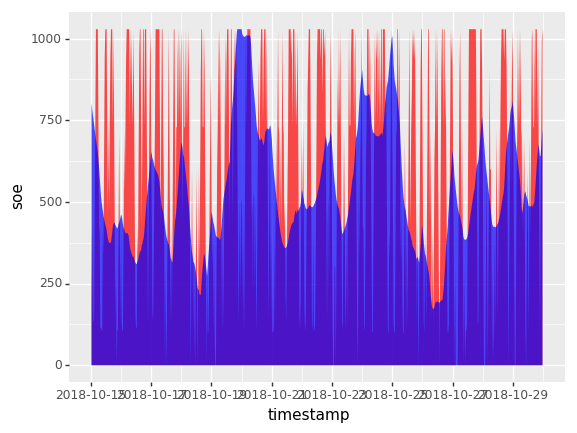

<ggplot: (293482977)>

In [104]:


(ggplot()
     +geom_area(results_mpc_short, aes(x='timestamp', y = "soe"), alpha = .7, fill = "red")
    +geom_area(results_nn_short, aes(x='timestamp', y = "soe"), alpha = .7, fill = "blue"))

In [29]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=results_nn['timestamp'], y=results_nn['k'], name='k'), secondary_y=False)

# Add figure title
fig.update_layout(
    font=dict(family='Courier New, monospace', size=18, color='black'),
    legend_orientation="h",
    legend=go.layout.Legend(
        x=0.76,
        y=0,
        traceorder="normal",
        font=dict(
            family="Courier New, monospace",
            size=17,
        )),
    )

# Set x-axis title
fig.update_xaxes(title_text="Hours of day")

# Set y-axes titles
fig.update_yaxes(title_text="Risk Factor")

fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



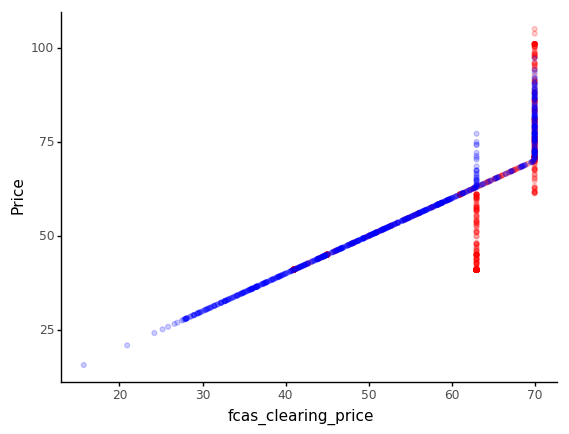

<ggplot: (285588358)>

In [128]:

start = pd.Timestamp(year=2018,
                     month=10,
                     day=15,
                     hour=0,
                     minute=0)
end = pd.Timestamp(year=2018,
                     month=10,
                     day=30,
                     hour=0,
                     minute=0)

results_mpc_short = results_mpc[(results_mpc['timestamp'] > start) & (results_mpc['timestamp'] < end)]
results_nn_short = results_nn[(results_nn['timestamp'] > start) & (results_nn['timestamp'] < end)]

results_nn_short["b_fcas_power"] = [float(i) for i in results_nn_short["b_fcas_power"]]

(ggplot()
    + geom_point(results_mpc_short, 
                 aes("fcas_clearing_price","battery_bid_fcas_price"), 
                 color = "red",
                alpha=.2)
    + geom_point(results_nn_short, 
                 aes("fcas_clearing_price","b_fcas_price"), 
                 color = "blue",
                alpha= .2)
    + ylab("Price")
    + theme_classic()
    )

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



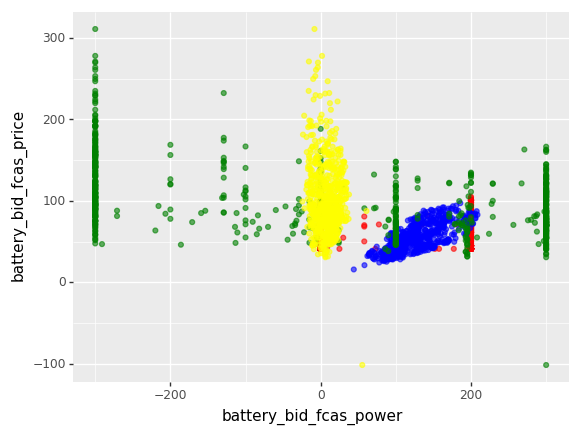

<ggplot: (-9223372036567193312)>

In [102]:
results_mpc_short["combined_bid_energy_power"] = \
     results_mpc_short["battery_bid_energy_power_load"].values + \
    results_mpc_short["battery_bid_energy_power_gen"].values
                                                                   

(ggplot(results_mpc_short)
    + geom_point(aes(x="battery_bid_fcas_power", y ="battery_bid_fcas_price"), 
                 color = "red",
                alpha = .6)
    + geom_point(data= results_nn_short, 
                 mapping=aes("b_fcas_actor_power", "b_fcas_price"),
                color = "blue",
                alpha=.6)
    + geom_point(data = results_mpc_short,
                mapping=aes(x="combined_bid_energy_power", y ="battery_bid_energy_price"), 
                 color = "green",
                alpha = .6)
    + geom_point(data = results_nn_short,
                mapping=aes(x="b_en_actor_power", y ="b_en_price"), 
                 color = "yellow",
                alpha = .6))

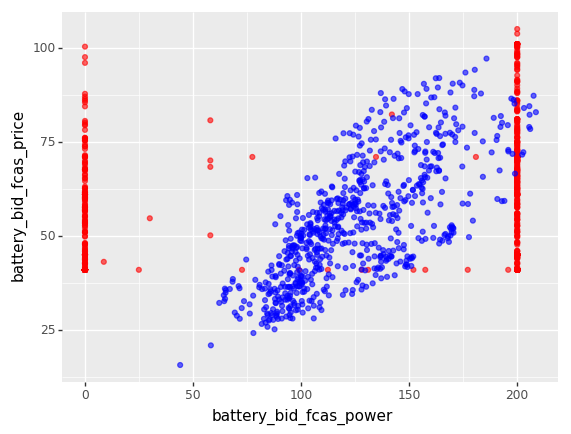

<ggplot: (-9223372036560803324)>

In [100]:
(ggplot(results_mpc_short)
    + geom_point(aes(x="battery_bid_fcas_power", y ="battery_bid_fcas_price"), 
                 color = "red",
                alpha = .6)
    + geom_point(data= results_nn_short, 
                 mapping=aes("b_fcas_actor_power", "b_fcas_price"),
                color = "blue",
                alpha=.6))

In [124]:
type(results_nn_short.b_fcas_power.values[0])

str

## Power vs. price for fcas and energy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



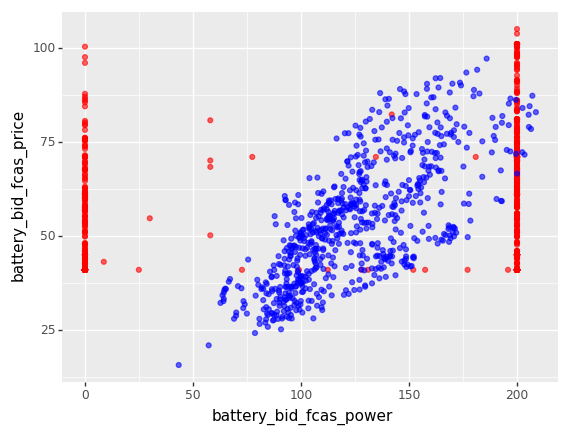

<ggplot: (-9223372036563686091)>

In [127]:
## plot 1

results_nn_short["b_fcas_power"] = [float(i) for i in results_nn_short["b_fcas_power"]]

(ggplot()
    + geom_point(data= results_mpc_short, 
                 mapping= aes(x="battery_bid_fcas_power", y ="battery_bid_fcas_price"), 
                 color = "red",
                alpha = .6)
    + geom_point(data=results_nn_short, 
                 mapping = aes(x="b_fcas_power", y ="b_fcas_price"),
                 color = "blue",
                alpha = .6)
)




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



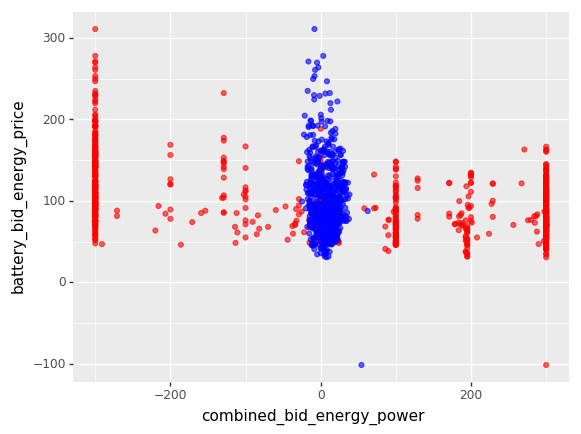

<ggplot: (-9223372036567193305)>

In [135]:
## Plot 2 
results_mpc_short["combined_bid_energy_power"] = \
     results_mpc_short["battery_bid_energy_power_load"].values + \
    results_mpc_short["battery_bid_energy_power_gen"].values
   
results_nn_short["b_en_power_combined"] = \
     results_nn_short["b_en_power_load"].values + \
    results_nn_short["b_en_power_gen"].values
            

(ggplot()
    + geom_point(data= results_mpc_short, 
                 mapping= aes(x="combined_bid_energy_power", y ="battery_bid_energy_price"), 
                 color = "red",
                alpha = .6)
    + geom_point(data=results_nn_short, 
                 mapping = aes(x="b_en_power_combined", y ="b_en_price"),
                 color = "blue",
                alpha = .6)
)


## Price by demand for fcas and energy

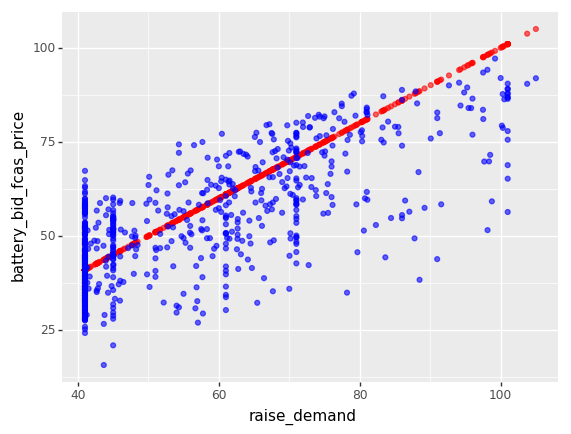

<ggplot: (293854286)>

In [131]:


(ggplot()
    + geom_point(data= results_mpc_short, 
                 mapping= aes(x="raise_demand", y ="battery_bid_fcas_price"), 
                 color = "red",
                alpha = .6)
    + geom_point(data=results_nn_short, 
                 mapping = aes(x="fcas_demand", y ="b_fcas_price"),
                 color = "blue",
                alpha = .6)
)


In [ ]:


(ggplot()
    + geom_point(data= results_mpc_short, 
                 mapping= aes(x="raise_demand", y ="battery_bid_fcas_price"), 
                 color = "red",
                alpha = .6)
    + geom_point(data=results_nn_short, 
                 mapping = aes(x="fcas_demand", y ="b_fcas_price"),
                 color = "blue",
                alpha = .6)
)



## ...Just kidding, not by energy. Below are some more exploratory plots.

In [ ]:
(ggplot()
    + geom_point(data= results_mpc_short, 
                 mapping= aes(x="battery_bid_fcas_power", y ="battery_bid_fcas_price"), 
                 color = "red",
                alpha = .6)
    + geom_point(data=results_nn_short, 
                 mapping = aes(x="b_fcas_power", y ="b_fcas_price"), 
                 color = "red",
                alpha = .6)
)

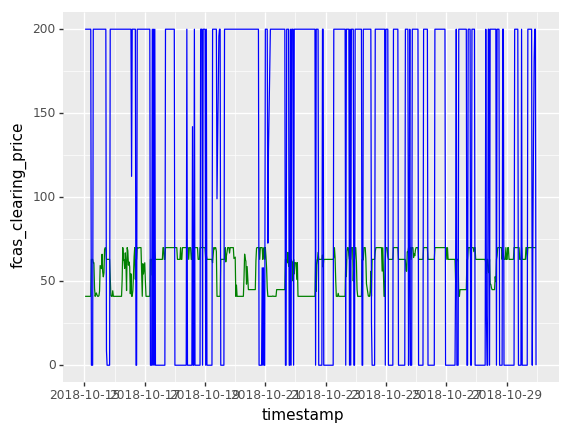

<ggplot: (294779235)>

In [74]:
(ggplot(results_mpc_short)
    + geom_line(aes("timestamp", "fcas_clearing_price"), color = "green")
    + geom_line(aes("timestamp", "battery_bid_fcas_power"), color = "blue")
)

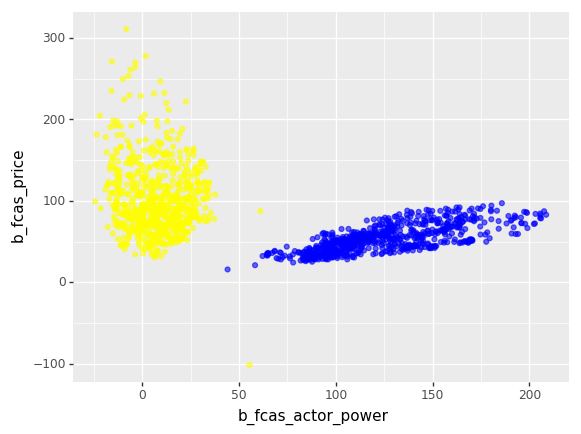

<ggplot: (291205117)>

In [81]:
(ggplot(results_mpc_short)
    + geom_point(data= results_nn_short, 
                 mapping=aes("b_fcas_actor_power", "b_fcas_price"),
                color = "blue",
                alpha=.6)
    + geom_point(data = results_nn_short,
                mapping=aes(x="b_en_actor_power", y ="b_en_price"), 
                 color = "yellow",
                alpha = .6))

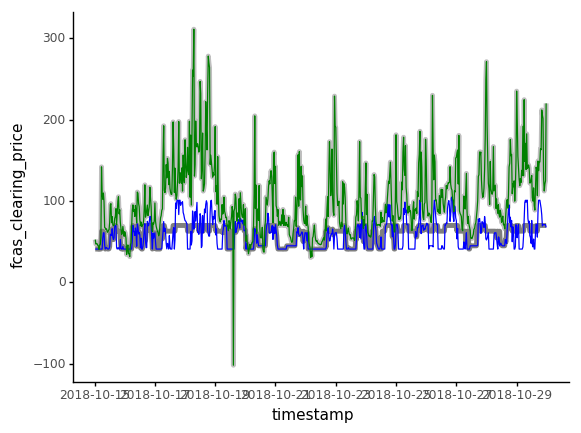

<ggplot: (293764314)>

In [99]:
(ggplot(results_mpc_short)
    + geom_line(aes("timestamp", "fcas_clearing_price"), color = "black", size = 2, alpha = .5)
    + geom_line(aes("timestamp", "energy_price"), color = "grey", size = 2, alpha = .5)
    + geom_line(aes("timestamp", "battery_bid_fcas_price"), color = "blue")
    + geom_line(aes("timestamp", "battery_bid_energy_price"), color = "green")
     +theme_classic()
)

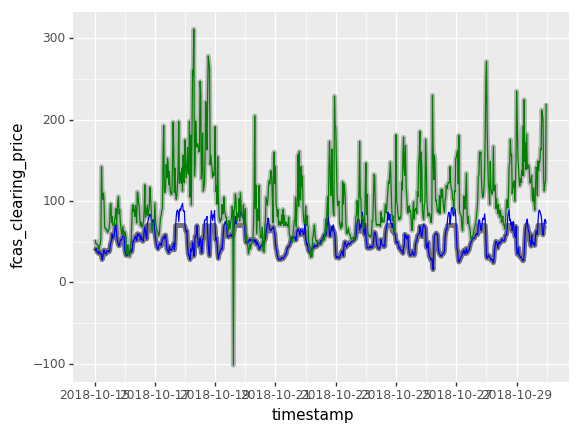

<ggplot: (293972614)>

In [98]:
(ggplot(results_nn_short)
    + geom_line(aes("timestamp", "fcas_clearing_price"), color = "black", size = 2, alpha = .5)
    + geom_line(aes("timestamp", "en_price"), color = "grey", size = 2, alpha = .5)
    + geom_line(aes("timestamp", "b_fcas_price"), color = "blue")
    + geom_line(aes("timestamp", "b_en_price"), color = "green")
)